# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# 1. Import libaries / Load data

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2. Exploratory Data Analysis (EDA)

### Data Set 1: "portfolio"

In [2]:
# show all rows of data set 'portfolio'
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# show descriptive statistics
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


### Data Set 2: "profile"

In [4]:
# show first 5 rows of data set 'profile'
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
# show descriptive statistics
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


### Data Set 3: "transcript"

In [6]:
# show first 5 rows of data set 'transcript'
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# 3. Basic Cleaning and Transformation

## 3.1 Data Frame 'portfolio'

In [8]:
# renaming column 'id' to 'offer_id' to avoid confusion with columns in other data sets
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [9]:
# replace offer_ids with numbers for better readability
# create a mapping directory
offer_id_map = {id_: i+1 for i, id_ in enumerate(portfolio['offer_id'].unique())}
offer_id_map

{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

In [10]:
# map id's
portfolio['offer_id'] = portfolio['offer_id'].map(offer_id_map)

In [11]:
# show transformed data frame
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,1
1,10,"[web, email, mobile, social]",10,5,bogo,2
2,0,"[web, email, mobile]",0,4,informational,3
3,5,"[web, email, mobile]",5,7,bogo,4
4,5,"[web, email]",20,10,discount,5
5,3,"[web, email, mobile, social]",7,7,discount,6
6,2,"[web, email, mobile, social]",10,10,discount,7
7,0,"[email, mobile, social]",0,3,informational,8
8,5,"[web, email, mobile, social]",5,5,bogo,9
9,2,"[web, email, mobile]",10,7,discount,10


## 3.2 Data Frame 'profile'

In [12]:
# rename column 'id' to 'customer_id'
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [13]:
# check all null values
profile.isnull().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
dtype: int64

## 3.3 Data Frame 'transcript'

In [14]:
# replace column name 'person' with 'customer_id'
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [15]:
# get all keys from 'value'
all_keys = set().union(*(row.keys() for row in transcript['value']))
print(all_keys)

{'offer_id', 'amount', 'offer id', 'reward'}


In [16]:
# expand the dictionary to coulmns 
for i in all_keys:
    transcript[i] = transcript['value'].apply(lambda x: x.get(i))
    
# move values from 'offer id'  to 'offer_id' (note the underscore)
transcript['offer_id'] = np.where(transcript['offer_id'].isnull(), transcript['offer id'], transcript['offer_id'])

# 'offer id' and 'value' column is no longer used -> drop it
transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)

# map offer_ids with above mapping dict
transcript['offer_id'] = transcript['offer_id'].map(offer_id_map)

# replace nan
transcript.fillna(0 , inplace=True)

In [17]:
# get dummies for event column and merge back to original df
transcript_event = pd.get_dummies(transcript['event'], dtype=int)
transcript = pd.concat([transcript, transcript_event], axis=1)
transcript = transcript.drop(columns='event')

# rename new columns
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'})

,customer_id,time,offer_id,amount,reward,offer_completed,offer_received,offer_viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,4.0,0.00,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.00,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,10.0,0.00,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.00,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.00,0.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0.0,1.59,0.0,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0.0,9.53,0.0,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,0.0,3.61,0.0,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0.0,3.53,0.0,0,0,0,1


## 3.4 Merge Data Frames

In [18]:
# in first step, merge df transcript with df profile on column 'customer id'
df_merged_temp = transcript.merge(profile, how='left', on='customer_id')

In [19]:
df_merged_temp

,customer_id,time,offer_id,amount,reward,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,4.0,0.00,0.0,0,1,0,0,F,75,20170509,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.00,0.0,0,1,0,0,None,118,20170804,NaN
2,e2127556f4f64592b11af22de27a7932,0,10.0,0.00,0.0,0,1,0,0,M,68,20180426,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.00,0.0,0,1,0,0,None,118,20170925,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.00,0.0,0,1,0,0,None,118,20171002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0.0,1.59,0.0,0,0,0,1,M,66,20180101,47000.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0.0,9.53,0.0,0,0,0,1,M,52,20180408,62000.0
306531,a00058cf10334a308c68e7631c529907,714,0.0,3.61,0.0,0,0,0,1,F,63,20130922,52000.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0.0,3.53,0.0,0,0,0,1,M,57,20160709,40000.0


In [20]:
# in second step, merge df portfolio on column 'offer_id'
df_merged_final = pd.merge(df_merged_temp, portfolio, on='offer_id', how='left')

In [21]:
# drop column 'reward_x'
df_final = df_merged_final.drop(columns={'reward_x'})

# rename columns
df_final = df_final.rename(columns={'reward_y': 'reward'})
df_final = df_final.rename(columns={'offer completed': 'offer_completed'})
df_final = df_final.rename(columns={'offer received': 'offer_received'})
df_final = df_final.rename(columns={'offer viewed': 'offer_viewed'})

In [22]:
# show final merged df
df_final.head()

,customer_id,time,offer_id,amount,offer_completed,offer_received,offer_viewed,transaction,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,0,4.0,0.0,0,1,0,0,F,75,20170509,100000.0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.0,0,1,0,0,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,0,10.0,0.0,0,1,0,0,M,68,20180426,70000.0,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.0,0,1,0,0,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.0,0,1,0,0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


## 3.5 Statistics from final data frame

In [23]:
# get total number of unique customer in this df
print("total number of cumstomers: {}".format(df_final.customer_id.nunique()))

total number of cumstomers: 17000


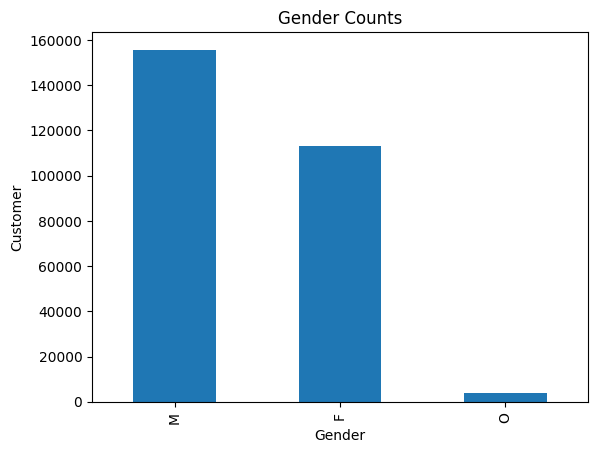

In [24]:
# show plot of gender distribution
df_final.gender.value_counts().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Customer')
plt.title('Gender Counts')
plt.show()

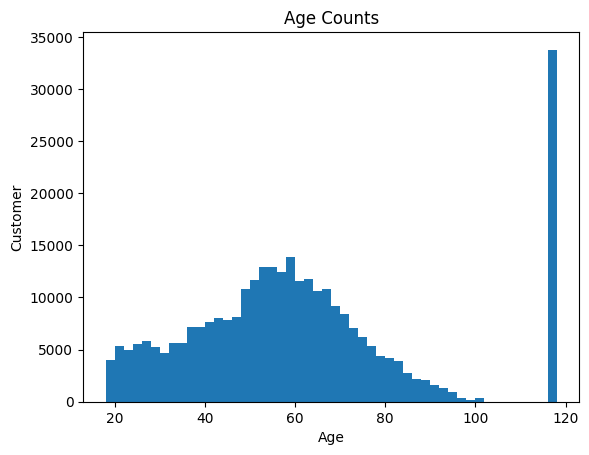

In [25]:
# show plot of age distribution
df_final.age.plot(kind='hist', bins=50)
plt.xlabel('Age')
plt.ylabel('Customer')
plt.title('Age Counts')
plt.show()

In [26]:
# how many persons are in the dataset with age 118 ?
df_final[df_final['age'] == 118]

,customer_id,time,offer_id,amount,offer_completed,offer_received,offer_viewed,transaction,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.00,0,1,0,0,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.00,0,1,0,0,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.00,0,1,0,0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo
6,c4863c7985cf408faee930f111475da3,0,6.0,0.00,0,1,0,0,None,118,20170824,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount
10,744d603ef08c4f33af5a61c8c7628d1c,0,5.0,0.00,0,1,0,0,None,118,20170801,NaN,5.0,"[web, email]",20.0,10.0,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,6.0,0.00,1,0,0,0,None,118,20170116,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount
306505,b895c57e8cd047a8872ce02aa54759d6,714,0.0,4.48,0,0,0,1,None,118,20170125,NaN,NaN,NaN,NaN,NaN,NaN
306506,b895c57e8cd047a8872ce02aa54759d6,714,7.0,0.00,1,0,0,0,None,118,20170125,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
306528,5ca2620962114246ab218fc648eb3934,714,0.0,2.20,0,0,0,1,None,118,20171029,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# check if all gender and income are 'None' when age is set to 118
df_final[
    (df_final['age']==118) &
    (df_final['gender'].isna()) &
    (df_final['income'].isnull())
       ]

,customer_id,time,offer_id,amount,offer_completed,offer_received,offer_viewed,transaction,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.00,0,1,0,0,None,118,20170804,NaN,5.0,"[web, email]",20.0,10.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.00,0,1,0,0,None,118,20170925,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.00,0,1,0,0,None,118,20171002,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo
6,c4863c7985cf408faee930f111475da3,0,6.0,0.00,0,1,0,0,None,118,20170824,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount
10,744d603ef08c4f33af5a61c8c7628d1c,0,5.0,0.00,0,1,0,0,None,118,20170801,NaN,5.0,"[web, email]",20.0,10.0,discount
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,6.0,0.00,1,0,0,0,None,118,20170116,NaN,3.0,"[web, email, mobile, social]",7.0,7.0,discount
306505,b895c57e8cd047a8872ce02aa54759d6,714,0.0,4.48,0,0,0,1,None,118,20170125,NaN,NaN,NaN,NaN,NaN,NaN
306506,b895c57e8cd047a8872ce02aa54759d6,714,7.0,0.00,1,0,0,0,None,118,20170125,NaN,2.0,"[web, email, mobile, social]",10.0,10.0,discount
306528,5ca2620962114246ab218fc648eb3934,714,0.0,2.20,0,0,0,1,None,118,20171029,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# show descriptive statistics
df_final.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

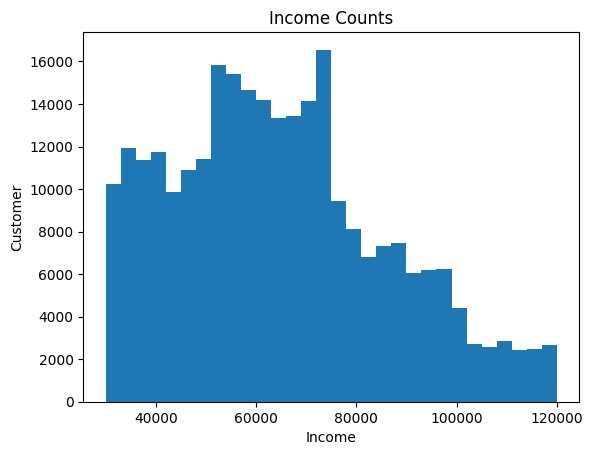

In [29]:
# show plot of income distribution
df_final.income.plot(kind='hist', bins=30)
plt.xlabel('Income')
plt.ylabel('Customer')
plt.title('Income Counts')
plt.show()

In [30]:
# show the ratio of offers received / viewd / completed
offer_received = df_final[df_final['offer_received'] == 1].offer_type.value_counts()
offer_viewed = df_final[df_final['offer_viewed'] == 1].offer_type.value_counts()
offer_completed = df_final[df_final['offer_completed'] == 1].offer_type.value_counts()

In [31]:
def plot_offer_type_counts(
    data,
    event_columns,
    event_labels=None,
    figsize=(15, 5),
    kind='bar'
):
    """
    Plots value counts of offer types for given event columns in subplots.
    
    Parameters:
        data: pandas.DataFrame
            DataFrame containing the data.
        event_columns: list of str
            List of column names for the events (e.g. ['offer-received', 'offer-viewed', ...]).
        event_labels: list of str, optional
            List of titles for the subplots. If None, uses event_columns.
        figsize: tuple, optional
            Figure size.
        kind: str, optional
            Plot kind for pandas.Series.plot (default: 'bar').
    """
    n_events = len(event_columns)
    if event_labels is None:
        event_labels = event_columns

    fig, axes = plt.subplots(1, n_events, figsize=figsize)

    if n_events == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, col, label in zip(axes, event_columns, event_labels):
        counts = data[data[col] == 1].offer_type.value_counts()
        counts.plot(kind=kind, ax=ax)
        ax.set_ylabel('counts')
        ax.set_xlabel('Offer Type')
        ax.set_title(f'{label}')

    plt.tight_layout()
    plt.show()

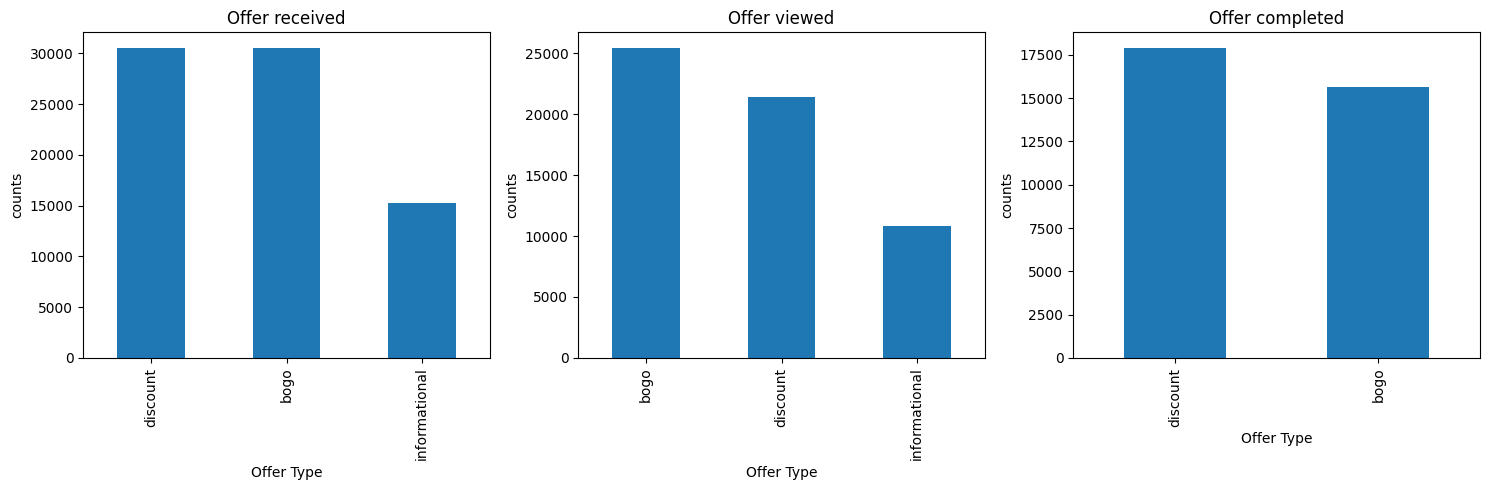

In [32]:
plot_offer_type_counts(
    df_final,
    event_columns=['offer_received', 'offer_viewed', 'offer_completed'],
    event_labels=['Offer received', 'Offer viewed', 'Offer completed']
)

In [33]:
# DISCOUNT

discount_received = offer_received.iloc[0] 
discount_viewed = offer_viewed.iloc[1] 
discount_completed = offer_completed.iloc[0] 

# calc ratios:
view_ratio = discount_viewed/discount_received
completed_ratio = discount_completed/discount_received

print("DISCOUNT (received)", discount_received)
print("DISCOUNT (viewed)", discount_viewed)
print("DISCOUNT (completed)", discount_completed)

print("DISCOUNT (ratio viewed / received) {} %".format(view_ratio))
print("DISCOUNT (ratio completed / received) {} %".format(completed_ratio))

DISCOUNT (received) 30543
DISCOUNT (viewed) 21445
DISCOUNT (completed) 17910
DISCOUNT (ratio viewed / received) 0.702124873129686 %
DISCOUNT (ratio completed / received) 0.5863864060504862 %


In [34]:
# BOGO

bogo_received = offer_received.iloc[1] 
bogo_viewed = offer_viewed.iloc[0] 
bogo_completed = offer_completed.iloc[1] 

# calc ratios:
view_ratio = bogo_viewed/bogo_received
completed_ratio = bogo_completed/bogo_received

print("BOGO (received)", bogo_received)
print("BOGO (viewed)", bogo_viewed)
print("BOGO (completed)", bogo_completed)

print("BOGO (ratio viewed / received) {} %".format(view_ratio))
print("BOGO (ratio completed / received) {} %".format(completed_ratio))

BOGO (received) 30499
BOGO (viewed) 25449
BOGO (completed) 15669
BOGO (ratio viewed / received) 0.8344208006819895 %
BOGO (ratio completed / received) 0.5137545493294862 %


### Some insights / thougths from the data

- The total number of unique customer in this data is 17000
- There is more male than female in this data
- There is 33772 entries with age 118 and null for gender and income. This means that missing age information is entered as '118' -> Consider dropping these from df
- most customer are in their 50s and 60s
- DISCOUNT offers are completed more likely than BOGO
- BOGO offers are viewed with a chance of 83 %
- DISCOUNT offers viewed with a chance of 70 %



# 4. Modelling

In [35]:
# process categorical values
gender_dummies = pd.get_dummies(df_final['gender'], prefix='gender', dummy_na=True, dtype=int)

# Concatenate the new columns to the original DataFrame
df_final = pd.concat([df_final, gender_dummies], axis=1)

# Drop the original 'gender' column
df_final = df_final.drop('gender', axis=1)

# process channels column 
# df_final = df_final.drop('channels', 1).join(df_final.channels.str.join('|').str.get_dummies())

In [36]:
# process categorical values
offer_type_dummies = pd.get_dummies(df_final['offer_type'], prefix='offer_type', dummy_na=True, dtype=int)

# Concatenate the new columns to the original DataFrame
df_final = pd.concat([df_final, offer_type_dummies], axis=1)

# Drop the original 'gender' column
df_final = df_final.drop('offer_type', axis=1)

In [37]:
df_final

,customer_id,time,offer_id,amount,offer_completed,offer_received,offer_viewed,transaction,age,became_member_on,...,difficulty,duration,gender_F,gender_M,gender_O,gender_nan,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type_nan
0,78afa995795e4d85b5d9ceeca43f5fef,0,4.0,0.00,0,1,0,0,75,20170509,...,5.0,7.0,1,0,0,0,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,5.0,0.00,0,1,0,0,118,20170804,...,20.0,10.0,0,0,0,1,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,10.0,0.00,0,1,0,0,68,20180426,...,10.0,7.0,0,1,0,0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,7.0,0.00,0,1,0,0,118,20170925,...,10.0,10.0,0,0,0,1,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,2.0,0.00,0,1,0,0,118,20171002,...,10.0,5.0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0.0,1.59,0,0,0,1,66,20180101,...,NaN,NaN,0,1,0,0,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0.0,9.53,0,0,0,1,52,20180408,...,NaN,NaN,0,1,0,0,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,0.0,3.61,0,0,0,1,63,20130922,...,NaN,NaN,1,0,0,0,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0.0,3.53,0,0,0,1,57,20160709,...,NaN,NaN,0,1,0,0,0,0,0,1


In [38]:
# show all columns in df_final
df_final.columns

Index(['customer_id', 'time', 'offer_id', 'amount', 'offer_completed',
       'offer_received', 'offer_viewed', 'transaction', 'age',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'gender_F', 'gender_M', 'gender_O', 'gender_nan',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'offer_type_nan'],
      dtype='object')

In [39]:
# Count how many times offer_completed == 1
num_completed = df_final['offer_completed'].sum()
print("Number of completed offers:", num_completed)

Number of completed offers: 33579


## 4.1 Gender


Feature importances for gender_F:


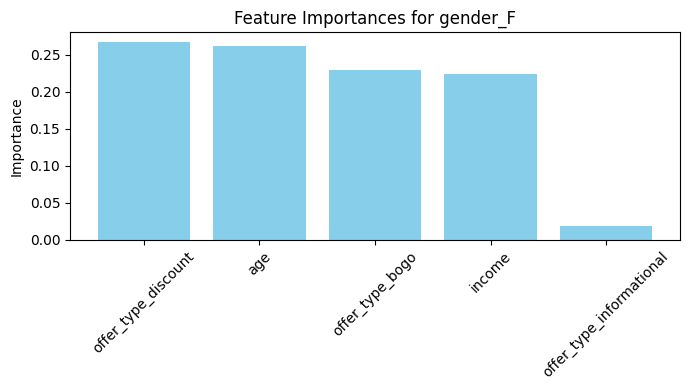

offer_type_discount: 0.267
age: 0.262
offer_type_bogo: 0.229
income: 0.224
offer_type_informational: 0.018

Feature importances for gender_M:


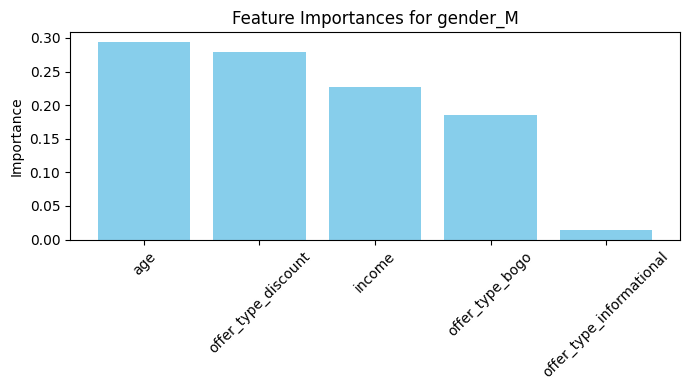

age: 0.294
offer_type_discount: 0.280
income: 0.227
offer_type_bogo: 0.185
offer_type_informational: 0.014

Feature importances for gender_O:


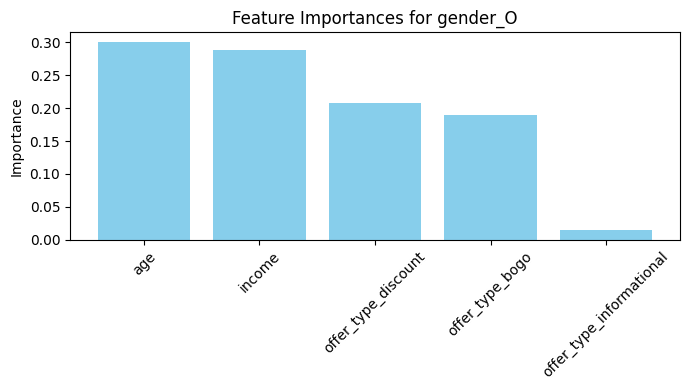

age: 0.300
income: 0.288
offer_type_discount: 0.208
offer_type_bogo: 0.190
offer_type_informational: 0.014


In [41]:
features = ['age', 'income', 'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']
target = 'offer_completed'

# Gender columns: 'gender_F', 'gender_M', 'gender_O'
genders = ['gender_F', 'gender_M', 'gender_O']

for gender in genders:
    print(f"\nFeature importances for {gender}:")
    # Filter for this gender
    df_gender = df_final[df_final[gender] == 1]
    # Drop missing values
    df_gender = df_gender[features + [target]].dropna()
    X = df_gender[features]
    y = df_gender[target]
    if len(df_gender) < 100:
        print("Not enough data.")
        continue
        
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Feature importances
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot
    plt.figure(figsize=(7, 4))
    plt.title(f"Feature Importances for {gender}")
    plt.bar(range(len(importances)), importances[indices], color="skyblue")
    plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
    # Print values
    for name, importance in zip(np.array(features)[indices], importances[indices]):
        print(f"{name}: {importance:.3f}")

## 4.2 Age


Feature importances for age group 65+:


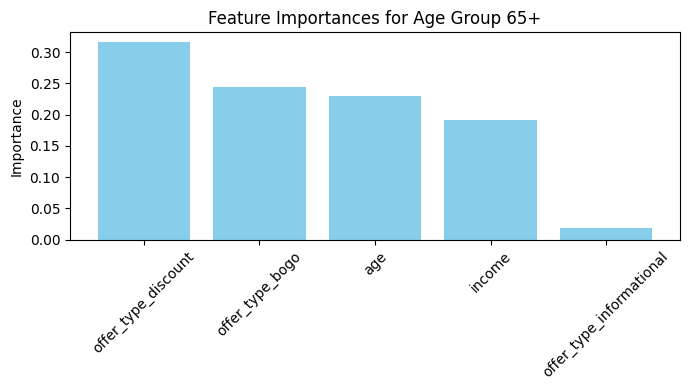

offer_type_discount: 0.316
offer_type_bogo: 0.245
age: 0.230
income: 0.191
offer_type_informational: 0.018

Feature importances for age group 51-65:


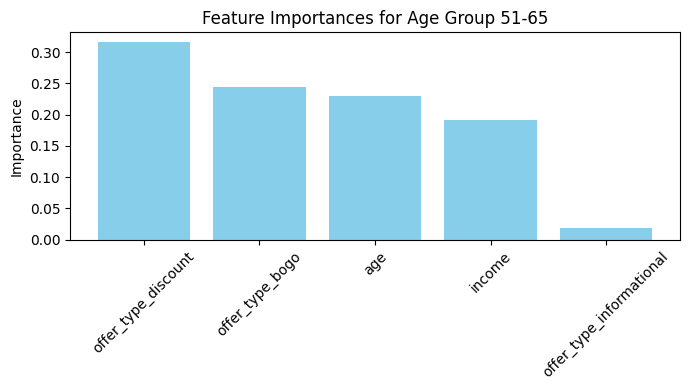

offer_type_discount: 0.316
offer_type_bogo: 0.245
age: 0.230
income: 0.191
offer_type_informational: 0.018

Feature importances for age group 36-50:


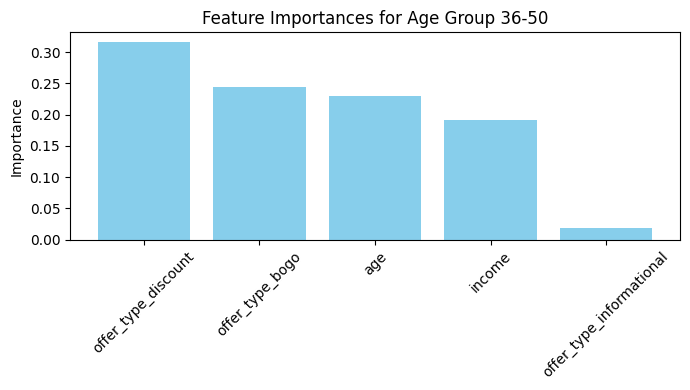

offer_type_discount: 0.316
offer_type_bogo: 0.245
age: 0.230
income: 0.191
offer_type_informational: 0.018

Feature importances for age group <25:


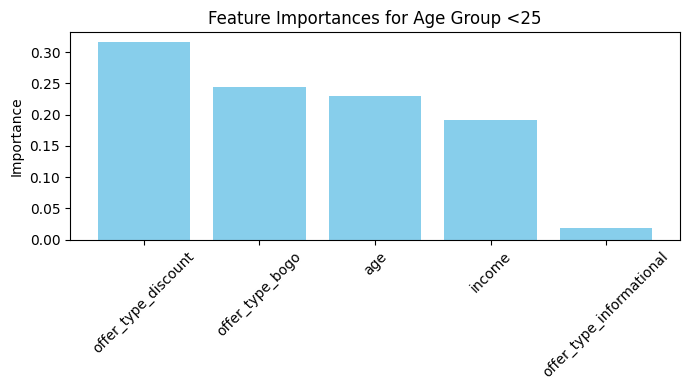

offer_type_discount: 0.316
offer_type_bogo: 0.245
age: 0.230
income: 0.191
offer_type_informational: 0.018

Feature importances for age group 25-35:


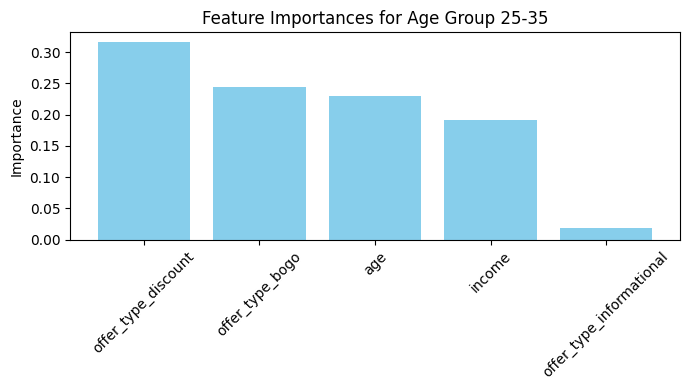

offer_type_discount: 0.316
offer_type_bogo: 0.245
age: 0.230
income: 0.191
offer_type_informational: 0.018


In [45]:
# Create age bins
df_final['age_bin'] = pd.cut(df_final['age'], bins=[0, 25, 35, 50, 65, 120], labels=['<25', '25-35', '36-50', '51-65', '65+'])

for age_bin in df_final['age_bin'].unique():
    print(f"\nFeature importances for age group {age_bin}:")
    df_age = df_final[df_final['age_bin'] == age_bin]
    df_age = df_final[features + [target]].dropna()
    X = df_age[features]
    y = df_age[target]
    if len(df_age) < 100:
        print("Not enough data.")
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(7, 4))
    plt.title(f"Feature Importances for Age Group {age_bin}")
    plt.bar(range(len(importances)), importances[indices], color="skyblue")
    plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
    
    for name, importance in zip(np.array(features)[indices], importances[indices]):
        print(f"{name}: {importance:.3f}")

## 4.3 Income


Feature importances for income group 80k+:


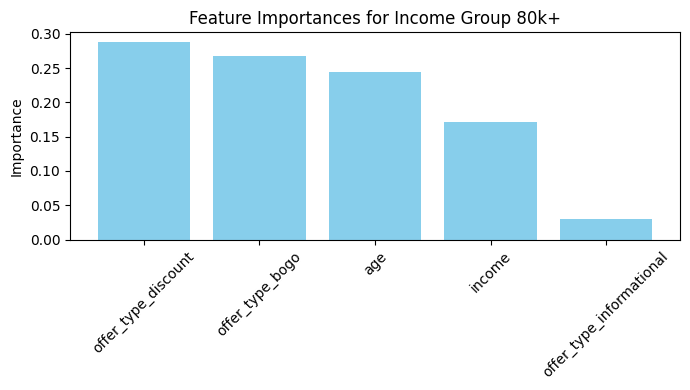

offer_type_discount: 0.288
offer_type_bogo: 0.268
age: 0.244
income: 0.171
offer_type_informational: 0.030

Feature importances for income group nan:
Not enough data.

Feature importances for income group 60-80k:


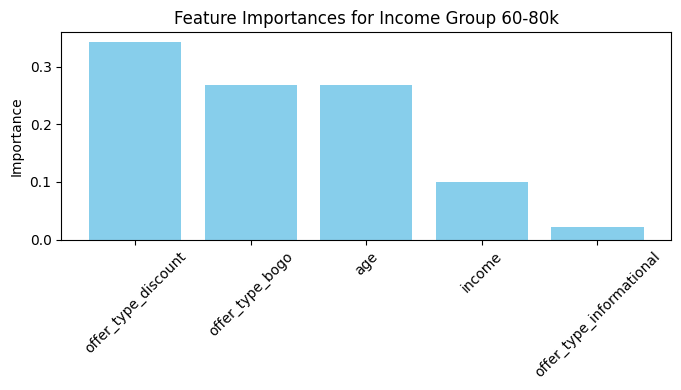

offer_type_discount: 0.342
offer_type_bogo: 0.269
age: 0.267
income: 0.100
offer_type_informational: 0.021

Feature importances for income group 40-60k:


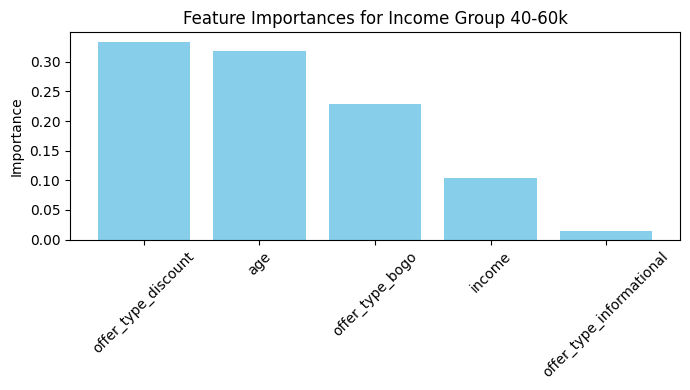

offer_type_discount: 0.333
age: 0.319
offer_type_bogo: 0.229
income: 0.104
offer_type_informational: 0.015

Feature importances for income group <40k:


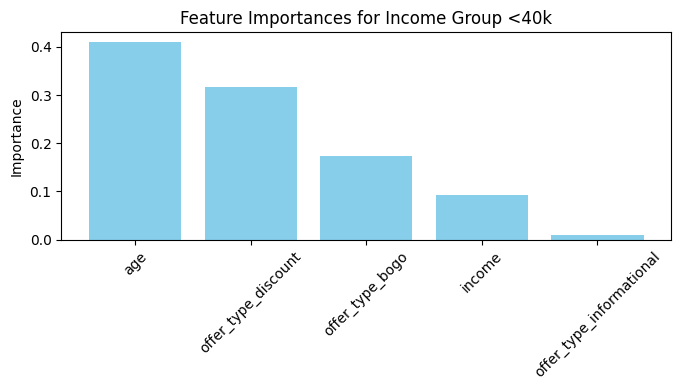

age: 0.410
offer_type_discount: 0.316
offer_type_bogo: 0.173
income: 0.091
offer_type_informational: 0.010


In [46]:
# Create income bins
df_final['income_bin'] = pd.cut(df_final['income'], bins=[0, 40000, 60000, 80000, 120000], labels=['<40k', '40-60k', '60-80k', '80k+'])

for income_bin in df_final['income_bin'].unique():
    print(f"\nFeature importances for income group {income_bin}:")
    df_income = df_final[df_final['income_bin'] == income_bin]
    df_income = df_income[features + [target]].dropna()
    X = df_income[features]
    y = df_income[target]
    if len(df_income) < 100:
        print("Not enough data.")
        continue
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(7, 4))
    plt.title(f"Feature Importances for Income Group {income_bin}")
    plt.bar(range(len(importances)), importances[indices], color="skyblue")
    plt.xticks(range(len(importances)), np.array(features)[indices], rotation=45)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()
    for name, importance in zip(np.array(features)[indices], importances[indices]):
        print(f"{name}: {importance:.3f}")
